# Задание на лабораторную работу

Тема: «Прогнозирование данных на основе множественной линейной регрессии»

Автор: Алексей Заузин, группа 4091

Цель работы: разработка приложения для прогнозирования цен на недвижимость.

Задачи:
1.	Загрузить выборку данных с сайта: https://www.kaggle.com/code/djuuuu/general-linear-models/data 
2.	Выбрать согласно варианту 3 входных параметра. Выходной параметр у всех одинаковый - price.
3.	Разбить выборку данных на тренировочную и тестовую.
4.	Нормализовать данные тренировочной выборки.
5.	Построить модель согласно варианту и обучить её на тренировочной выборке.
6.	Отобразить среднеквадратическую ошибку (RMSE). Сделать выводы о качестве работы модели исходя из значения ошибки и обосновать причины рассчитанной точности (перечислить предполагаемые факторы влияния).
7.	Визуализировать гистограммы рассчитанных и реальных значений прогнозируемого параметра. Сделать выводы о качестве работы модели исходя из анализа гистограммы.
8.	Представить функциональный вид обученной модели. Сделать вывод о влиянии отдельных входных параметров на расчёт выходного параметра.
9.	Сделать итоговый вывод о точности созданной модели на основание совокупного анализа всех использованных методов оценки.

Индивидуальное задание:
Модель: [Ridge Regression](https://scikit-learn.org/0.21/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

Параметры: bedrooms, waterfront, sqft_living

# Подготовка выборки
Загрузим и изучим выборку. Как мы видим ниже, примерно 10% вариантов значений цен имеют только один объект недвижимости, а дальнейшее изучение выборки дает понимание, что такие аномалии являются либо ошибками ввода (например, значения вроде 460.001 вместо 460.000), либо чрезмерной погрешностью оценки (например, 332.220 долларов).

In [38]:
import math

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("kc_house_data.csv")

y = data["price"]
X = data[["bedrooms", "waterfront", "sqft_living"]]

total = 0
ones = []
for c, v in y.value_counts().items():
    if v == 1:
        ones.append(c)
    total += v
print(total, len(ones))
print(pd.DataFrame(ones))

21613 2395
              0
0      724000.0
1     2271150.0
2      162950.0
3      919000.0
4      853505.0
...         ...
2390   607010.0
2391  1362500.0
2392   298800.0
2393   957500.0
2394   402101.0

[2395 rows x 1 columns]


Попробуем "спасти" такие значения округлив все цены до десятков тысяч долларов, т.к. меньшая погрешность является маловажной в изучаемом вопросе (рынок жилья в Сиэттле и его окресностях это объекты стоимостью сотни тысяч/миллионы долларов).

In [39]:
import pandas as pd
import numpy as np

data = pd.read_csv("kc_house_data.csv")

y = data["price"].apply(lambda x: int(10000 * round(float(x) / 10000)))
X = data[["bedrooms", "waterfront", "sqft_living"]]

total = 0
ones = []
for c, v in y.value_counts().items():
    if v == 1:
        ones.append(c)
    total += v
print(total, len(ones))
print(pd.DataFrame(ones))

21613 64
          0
0   3340000
1   1630000
2   5350000
3   2240000
4   5300000
..      ...
59  2530000
60  4210000
61  1930000
62  2410000
63  3570000

[64 rows x 1 columns]


Оставшиеся 64 значения мы просто выкинем из датасета как малозначимые выбросы

In [40]:
data = pd.read_csv("kc_house_data.csv")

y = data["price"].apply(lambda x: int(10000 * round(float(x) / 10000)))

total = 0
ones = []
for c, v in y.value_counts().items():
    if v == 1:
        ones.append(c)
    total += v

indieces_to_remove = [k for k, v in y.items() if v in ones]

data = pd.read_csv("kc_house_data.csv")
[data.drop(i, axis=0, inplace=True) for i in indieces_to_remove]
y = data["price"].apply(lambda x: int(10000 * round(float(x) / 10000)))
X = data[["bedrooms", "waterfront", "sqft_living"]]

print(len(y), len(X))

21549 21549


# Разделение выборки на тренировочную и тестовую

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [42]:
print(X_train)

       bedrooms  waterfront  sqft_living
1277          2           0         2630
395           2           0         1220
15082         3           0         1330
19324         3           0         3850
20060         4           0         2612
...         ...         ...          ...
11203         4           0         2040
11611         4           0         2090
12853         4           0         1880
1113          4           0         3030
21415         4           0         2245

[15084 rows x 3 columns]


# Нормализация данных

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Обучение модели на тренировочной выборке

In [44]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

Ridge()

# Делаем предсказание используя обученную модель

In [45]:
y_pred = ridge.predict(X_test)

# Определяем среднеквадратичную ошибку

In [46]:
from sklearn.metrics import mean_squared_error
import math
import statistics
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse, statistics.median(y_test))


baseline_prediction = np.median(y_train)
baseline_predictions = np.full_like(y_test, fill_value=baseline_prediction)
baseline_mse = mean_squared_error(y_test, baseline_predictions)
print(baseline_mse / mse)

233505.22800393906 450000
2.181042420177597


Показатель rmse равен 203305 долларам. Это очень высокое значение ошибки, учитывая медианную цену объекта недвижимости в 450.000 долларов.
Заметим, что тренированая модель дает результат примерно вдвое лучший, чем предсказание с использованием медианных значений аттрибутов. Вынесем гипотезу о том, что такой плохой результат вызван тем, что два параметра в выборке (кол-во квадратных футов площади, и количество спален) являются созависимыми.

In [47]:
print(X.corr())

             bedrooms  waterfront  sqft_living
bedrooms     1.000000   -0.012790     0.579654
waterfront  -0.012790    1.000000     0.074076
sqft_living  0.579654    0.074076     1.000000


Гипотеза подтвердилась. Учитывая, что третьим параметром является не очень информативный параметр сам по себе (близость к воде), по сути мы тренируем выборку на довольно некачественных параметрах.

# Рисуем гистограмму

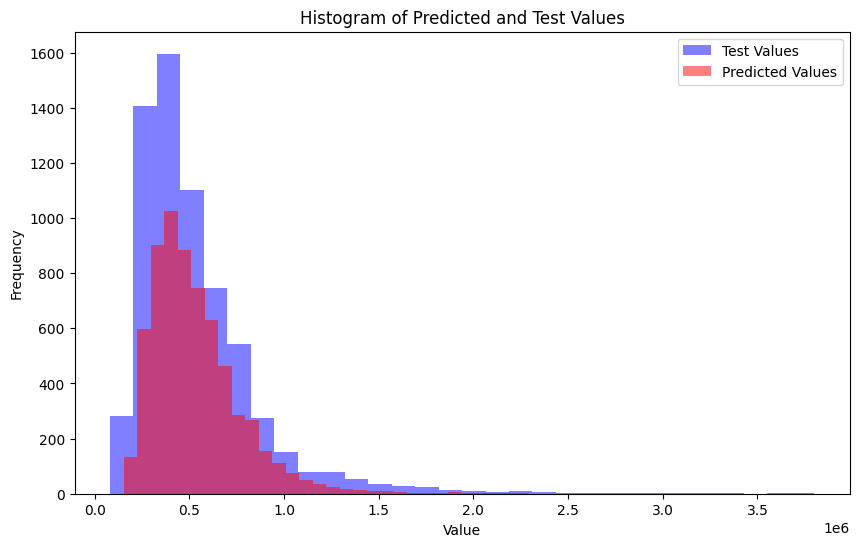

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.hist(y_test, bins=30, alpha=0.5, color='blue', label='Test Values')
plt.hist(y_pred, bins=30, alpha=0.5, color='red', label='Predicted Values')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted and Test Values')
plt.legend()

plt.show()

Из анализа гистограммы мы можем сделать вывод, что алгоритм оценки хоть и дает относительно схожее распределение значений оценки цены, но при этом стабильно переоценивает объекты недвижимости примерно на 50%, что является высокой погрешностью оценки. Вынесем гипотезу о том, что качество модели можно многократно улучшить добавив в нее параметры почтового индекса, года реновации жилья и категории жилья.

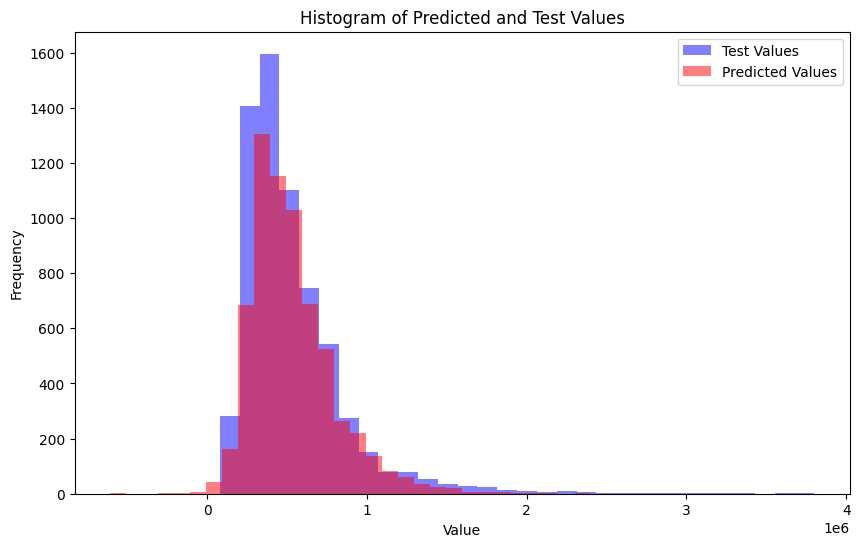

In [49]:
X = data[["bedrooms", "waterfront", "sqft_living", "zipcode", "yr_renovated", "yr_built", "grade"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

ridge_ex = Ridge(alpha=1.0)
ridge_ex.fit(X_train, y_train)
y_pred = ridge_ex.predict(X_test)

plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=30, alpha=0.5, color='blue', label='Test Values')
plt.hist(y_pred, bins=30, alpha=0.5, color='red', label='Predicted Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted and Test Values')
plt.legend()
plt.show()

Как очевидно из графика, гипотеза подтвердилась.

# Функциональный вид модели

In [50]:
print("price = {} * bedrooms + {} * waterfront + {} * sqft_living".format(np.round(ridge.coef_[0], 2), np.round(ridge.coef_[1], 2), np.round(ridge.coef_[2], 2)))

price = -36990.72 * bedrooms + 57920.69 * waterfront + 245422.24 * sqft_living


Как видно из данной модели, наибольшее влияние на целевую характеристику имеет параметр количества квадратных футов площади жилья. При этом, количество комнат имеет отрицательное влияние на стоимость.

# Вывод

В результате выполнения лабораторной работы было разработано приложение для прогнозирование цен на недвижимость. Построена и обучена модель ридж-регрессии на основе входных данных в виде количества комнат, принадлежности жилья к классу жилья с видом на воду и количества квадратных футов площади жилья в г. Сиэттл и его окрестностях. Расчитанный RMSE говорит о довольно высокой погрешности, что говорит о том, что алгоритм стабильно переоценивает жилье. При этом, распределение цен приблизильно совпадает с распределением цен в тестовой выборке. Низкое качество работы обученной модели объясняется не очень хорошим подбором параметров (два из них созависимы, а третий, сам по себе, не дает высокой точности). Обученная модель представлена в функциональном виде. Веса модели показывают, что наиболее влияющий фактор - количество квадратных футов метров жилья.